In [1]:
import os
import torch
import torchvision.transforms as transforms
from torchvision import datasets, models
from torch.utils.data import DataLoader
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split, cross_val_score
from imblearn.over_sampling import SMOTE
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
data_path = "/content/drive/My Drive/Datasets/potato"

In [ ]:
data_dir = data_path
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

dataset = datasets.ImageFolder(data_dir, transform=transform)
dataloader = DataLoader(dataset, batch_size=32, shuffle=False)
class_names = dataset.classes


In [ ]:
resnet = models.resnet50(pretrained=True)
resnet.fc = torch.nn.Identity()
resnet.eval()

features, labels = [], []

with torch.no_grad():
    for inputs, lbls in dataloader:
        output = resnet(inputs)
        features.append(output)
        labels.append(lbls)

features = torch.cat(features).numpy()
labels = torch.cat(labels).numpy()

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 151MB/s]


In [ ]:
smote = SMOTE(random_state=42)
features_resampled, labels_resampled = smote.fit_resample(features, labels)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    features_resampled, labels_resampled, test_size=0.2, stratify=labels_resampled, random_state=42)


In [ ]:
rf = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42)
scores = cross_val_score(rf, X_train, y_train, cv=5)
print("Cross-Validation Accuracy Scores:", scores)
print("Mean CV Accuracy:", np.mean(scores))

rf.fit(X_train, y_train)
preds = rf.predict(X_test)

print("Random Forest Results - Test Set (with SMOTE + CV)")
print(confusion_matrix(y_test, preds))
print(classification_report(y_test, preds, target_names=class_names))


Cross-Validation Accuracy Scores: [0.98333333 0.97916667 0.97708333 0.97916667 0.97708333]
Mean CV Accuracy: 0.9791666666666666
Random Forest Results - Test Set (with SMOTE + CV)
[[196   4   0]
 [  1 198   1]
 [  0   2 198]]
                       precision    recall  f1-score   support

Potato___Early_blight       0.99      0.98      0.99       200
 Potato___Late_blight       0.97      0.99      0.98       200
     Potato___healthy       0.99      0.99      0.99       200

             accuracy                           0.99       600
            macro avg       0.99      0.99      0.99       600
         weighted avg       0.99      0.99      0.99       600



In [ ]:
test_accuracy = np.mean(preds == y_test)
print("Test Accuracy:", test_accuracy)


Test Accuracy: 0.9866666666666667


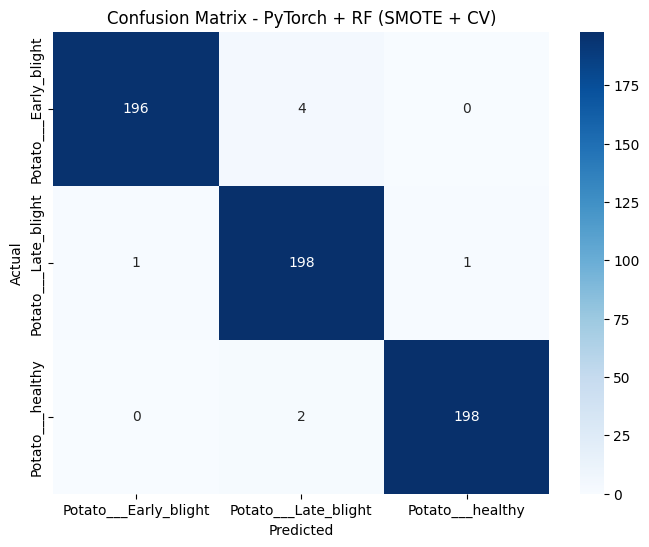

In [ ]:
cm = confusion_matrix(y_test, preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - PyTorch + RF (SMOTE + CV)")
plt.show()

In [ ]:
# Save the models
torch.save(resnet.state_dict(), 'resnet_feature_extractor.pth')  # Save ResNet feature extractor
joblib.dump(rf, 'random_forest_model.pkl')  # Save RandomForest model